In [4]:
import time
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

**Reading .mat files:**

In [5]:
img_mat = scipy.io.loadmat('images.mat')

In [6]:
img_mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Wed Feb 19 15:59:58 2014',
 '__version__': '1.0',
 '__globals__': [],
 'noisy_image': array([[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=uint8),
 'original_image': array([[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=uint8)}

In [7]:
print('Noisy image dimension : {}'.format(img_mat['noisy_image'].shape))
print('Original image dimension : {}'.format(img_mat['original_image'].shape))


Noisy image dimension : (160, 160)
Original image dimension : (160, 160)


In [8]:
# changing pixel values from {0, 1} to {-1, +1}
def sign(data, translate):

    temp = np.array(data)
    return np.vectorize(lambda x: translate[x])(temp)


img_noisy = sign(img_mat['noisy_image'], {0: -1, 1: 1})
img_orig = sign(img_mat['original_image'], {0: -1, 1: 1})

Text(0.5, 1.0, 'Noisy Image')

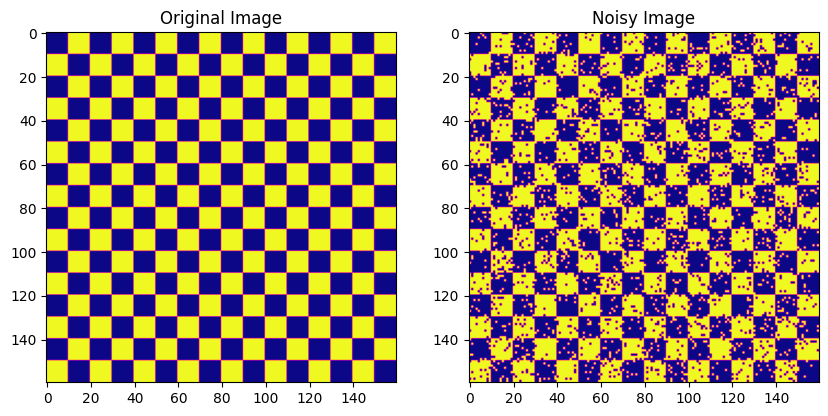

In [9]:
fig=plt.figure(figsize=(10, 10))
fig.add_subplot(2, 2, 1)   # subplot one
plt.imshow(img_orig, cmap='plasma')
plt.title('Original Image')

fig.add_subplot(2, 2, 2)   # subplot two
plt.imshow(img_noisy, cmap='plasma')
plt.title('Noisy Image')

**Energy function formula:** <br>
<br>
\begin{align}
E(x,y) = \alpha\sum_i{x_i} - \beta\sum_{i,j}{x_i x_j} - \gamma\sum_i{x_i y_i}
\end{align}


In [10]:
def E_generator(alpha, beta, gamma):

        def E(x, y):
                xxm = np.zeros_like(x)
                xxm[:-1, :] = x[1:, :]  # down
                xxm[1:, :] += x[:-1, :]  # up
                xxm[:, :-1] += x[:, 1:]  # right
                xxm[:, 1:] += x[:, :-1]  # left
                xx = np.sum(xxm * x)
                xy = np.sum(x * y)
                xsum = np.sum(x)

                return alpha * xsum - beta * xx - gamma * xy

        def is_valid(i, j, shape):
                # Checking validity of coordinates i, j in shape
                return i >= 0 and j >= 0 and i < shape[0] and j < shape[1]

        def localized_E(E1, i, j, x, y):

                old_val = x[i, j]
                new_val = old_val * -1  # flip
                # local computations
                E2 = E1 - (alpha * old_val) + (alpha * new_val)
                E2 = E2 + (gamma * y[i, j] * old_val) - (gamma * y[i, j] * new_val)
                adjacent = [(0, 1), (0, -1), (1, 0), (-1, 0)]
                neighbors = [x[i + di, j + dj] for di, dj in adjacent if is_valid(i + di, j + dj, x.shape)]
                E2 = E2 + beta * sum(a * old_val for a in neighbors)
                E2 = E2 - beta * sum(a * new_val for a in neighbors)

                return old_val, new_val, E1, E2

        return E, localized_E


def denoise(y, E, localized_E):
        # init
        x = np.array(y)
        Ebest = Ecur = E(x, y)  # initial energy
        initial_time = time.time()
        energy_record = [[0.0, ], [Ebest, ]]

        for idx in np.ndindex(y.shape):  # for each pixel in the matrix
                old, new, E1, E2 = localized_E(Ecur, idx[0], idx[1], x, y)
                if (E2 < Ebest):
                        Ecur, x[idx] = E2, new
                        Ebest = E2  # update Ebest
                else:
                        Ecur, x[idx] = E1, old

                if idx[1] == y.shape[1] - 1:
                        # recording time and Ebest of this iteration
                        used_time = time.time() - initial_time
                        energy_record[0].append(used_time)
                        energy_record[1].append(Ebest)


        return x, energy_record


Text(0.5, 1.0, 'Denoised Image')

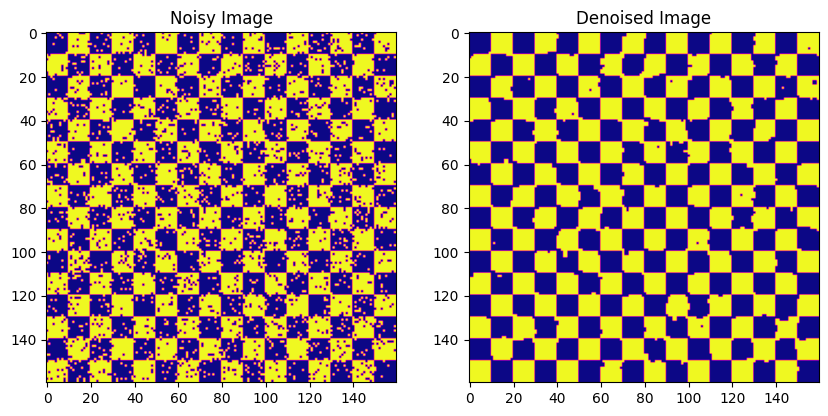

In [11]:
E, localized_E = E_generator(0, 2.1e-3, 1e-3)
result, energy_record = denoise(img_noisy, E, localized_E)
result = sign(result, {-1: 0, 1: 1})

fig=plt.figure(figsize=(10, 10, ))
fig.add_subplot(2, 2, 1)   # subplot one
plt.imshow(img_noisy, cmap='plasma')
plt.title('Noisy Image')

fig.add_subplot(2, 2, 2)   # subplot two
plt.imshow(result, cmap='plasma')
plt.title('Denoised Image')

**Calculating accuracy:**

In [12]:
count = 0
for i in range(160):
  for j in range(160):
    if (img_orig[i,j] == img_noisy[i,j]):
      count += 1

print('Accuracy: % {:.2f}'.format((count/(160*160))*100))

Accuracy: % 90.19


**Plot of Energy vs. Time:**

Text(0, 0.5, 'Energy')

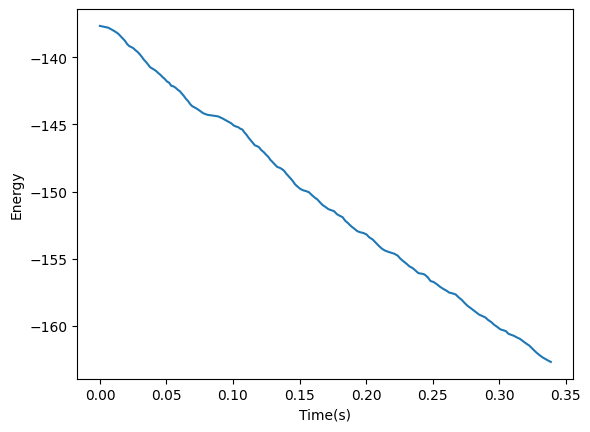

In [13]:
plt.plot(*energy_record)
plt.xlabel('Time(s)')
plt.ylabel('Energy')